In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create directories for outputs
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('preprocessing', exist_ok=True)
os.makedirs('correlation_analysis', exist_ok=True)
os.makedirs('time_series_analysis', exist_ok=True)
os.makedirs('final_report/figures', exist_ok=True)

######################################################################
## Phase 1: Data Loading and Initial Examination
######################################################################

In [3]:
print("Phase 1: Data Loading and Initial Examination")

Phase 1: Data Loading and Initial Examination


In [4]:
# Load the dataset
airquality = pd.read_excel('Dataset/AirQualityUCI.xlsx')

In [5]:
airquality.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [6]:
print(f"Dataset shape: {airquality.shape}")

Dataset shape: (9357, 15)


In [7]:
print("\nColumn names:")
print(airquality.columns.tolist())


Column names:
['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [8]:
airquality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [9]:
print("\nData types:")
print(airquality.dtypes)


Data types:
Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object


In [10]:
airquality.describe()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2004-09-21 04:30:05.193972480,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
min,2004-03-10 00:00:00,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,2004-06-16 00:00:00,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,2004-09-21 00:00:00,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2004-12-28 00:00:00,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,2005-04-04 00:00:00,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036
std,NaN,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670


In [11]:
airquality.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [12]:
# Check for missing values (represented as -200)
print("\nChecking for -200 values (missing data):")
for col in airquality.columns:
    if isinstance(airquality[col].min(), (int, float)) and airquality[col].min() == -200:
        print(f"{col} has -200 values: {(airquality[col] == -200).sum()} ({(airquality[col] == -200).sum()/len(airquality)*100:.2f}%)")


Checking for -200 values (missing data):
CO(GT) has -200 values: 1683 (17.99%)
PT08.S1(CO) has -200 values: 366 (3.91%)
C6H6(GT) has -200 values: 366 (3.91%)
PT08.S2(NMHC) has -200 values: 366 (3.91%)
NOx(GT) has -200 values: 1639 (17.52%)
PT08.S3(NOx) has -200 values: 366 (3.91%)
NO2(GT) has -200 values: 1642 (17.55%)
PT08.S4(NO2) has -200 values: 366 (3.91%)
PT08.S5(O3) has -200 values: 366 (3.91%)
T has -200 values: 366 (3.91%)
RH has -200 values: 366 (3.91%)
AH has -200 values: 366 (3.91%)


In [13]:
# Replace -200 with NaN
airquality = airquality.copy()
for col in airquality.columns:
    if airquality[col].dtype != 'datetime64[ns]' and airquality[col].dtype != 'object':
        airquality[col] = airquality[col].replace(-200, np.nan)

In [14]:
# # Impute missing values (example: mean imputation for numeric columns)
# numeric_cols = airquality.select_dtypes(include=[np.number]).columns
# airquality[numeric_cols] = airquality[numeric_cols].fillna(airquality[numeric_cols].mean())

In [15]:
# Check for missing values (represented as -200)
print("\nChecking for -200 values (missing data):")
for col in airquality.columns:
    if isinstance(airquality[col].min(), (int, float)) and airquality[col].min() == -200:
        print(f"{col} has -200 values: {(airquality[col] == -200).sum()} ({(airquality[col] == -200).sum()/len(airquality)*100:.2f}%)")


Checking for -200 values (missing data):


In [16]:
# Check for duplicates
duplicates = airquality.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [17]:
airquality.isnull().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [18]:
# Save basic statistics to a file
with open('data/data_description.txt', 'w') as f:
    f.write('# Air Quality Dataset - Exploratory Data Analysis\n\n')
    f.write('## Dataset Overview\n')
    f.write(f'Number of observations: {airquality.shape[0]}\n')
    f.write(f'Number of variables: {airquality.shape[1]}\n\n')
    
    f.write('## Variable Types\n')
    f.write(str(airquality.dtypes) + '\n\n')
    
    # Convert -200 values to NaN for better statistics
    df_clean = airquality.copy()
    for col in df_clean.columns:
        if df_clean[col].dtype != 'datetime64[ns]' and df_clean[col].dtype != 'object':
            df_clean.loc[df_clean[col] == -200, col] = np.nan
    
    f.write('## Summary Statistics (after replacing -200 with NaN)\n')
    f.write(str(df_clean.describe()) + '\n\n')
    
    f.write('## Missing Values (counting -200 as missing)\n')
    missing_counts = df_clean.isna().sum()
    missing_percent = (df_clean.isna().sum() / len(df_clean)) * 100
    missing_data = pd.DataFrame({'Missing Count': missing_counts, 'Missing Percent': missing_percent})
    f.write(str(missing_data) + '\n\n')

print("Initial data examination completed. Results saved to data/data_description.txt")

Initial data examination completed. Results saved to data/data_description.txt


################################################################
## Phase 2: Exploratory Data Analysis (EDA)
################################################################

In [19]:
print("\nPhase 2: Exploratory Data Analysis")


Phase 2: Exploratory Data Analysis


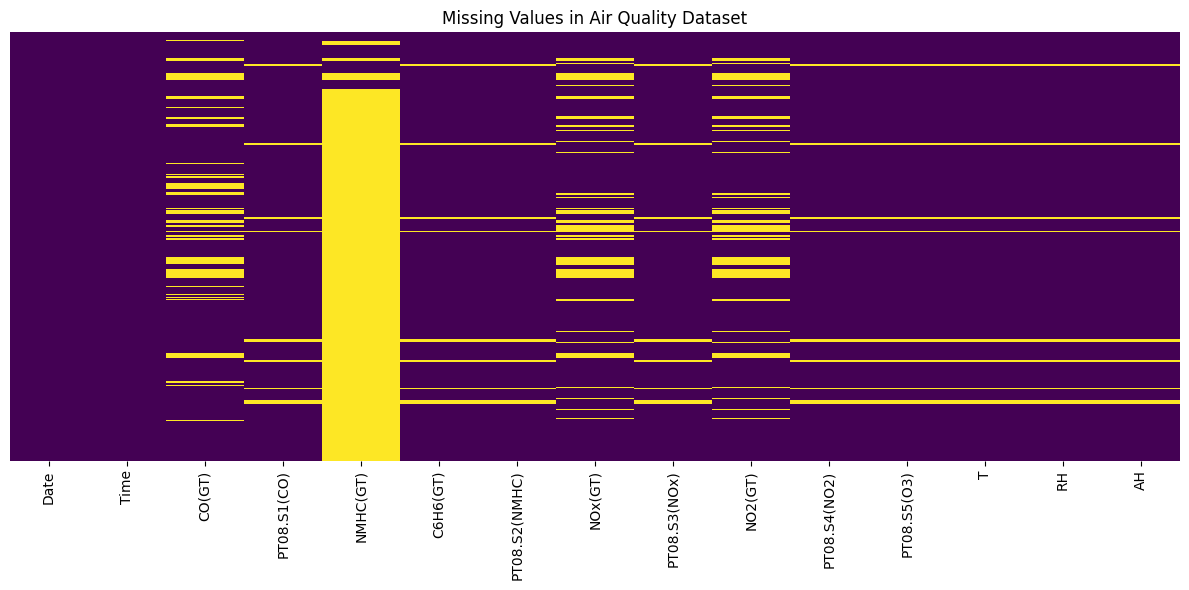

In [21]:
# Create a figure for missing values visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df_clean.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values in Air Quality Dataset')
plt.tight_layout()
plt.savefig('figures/missing_values.png')
plt.show() 
plt.close()

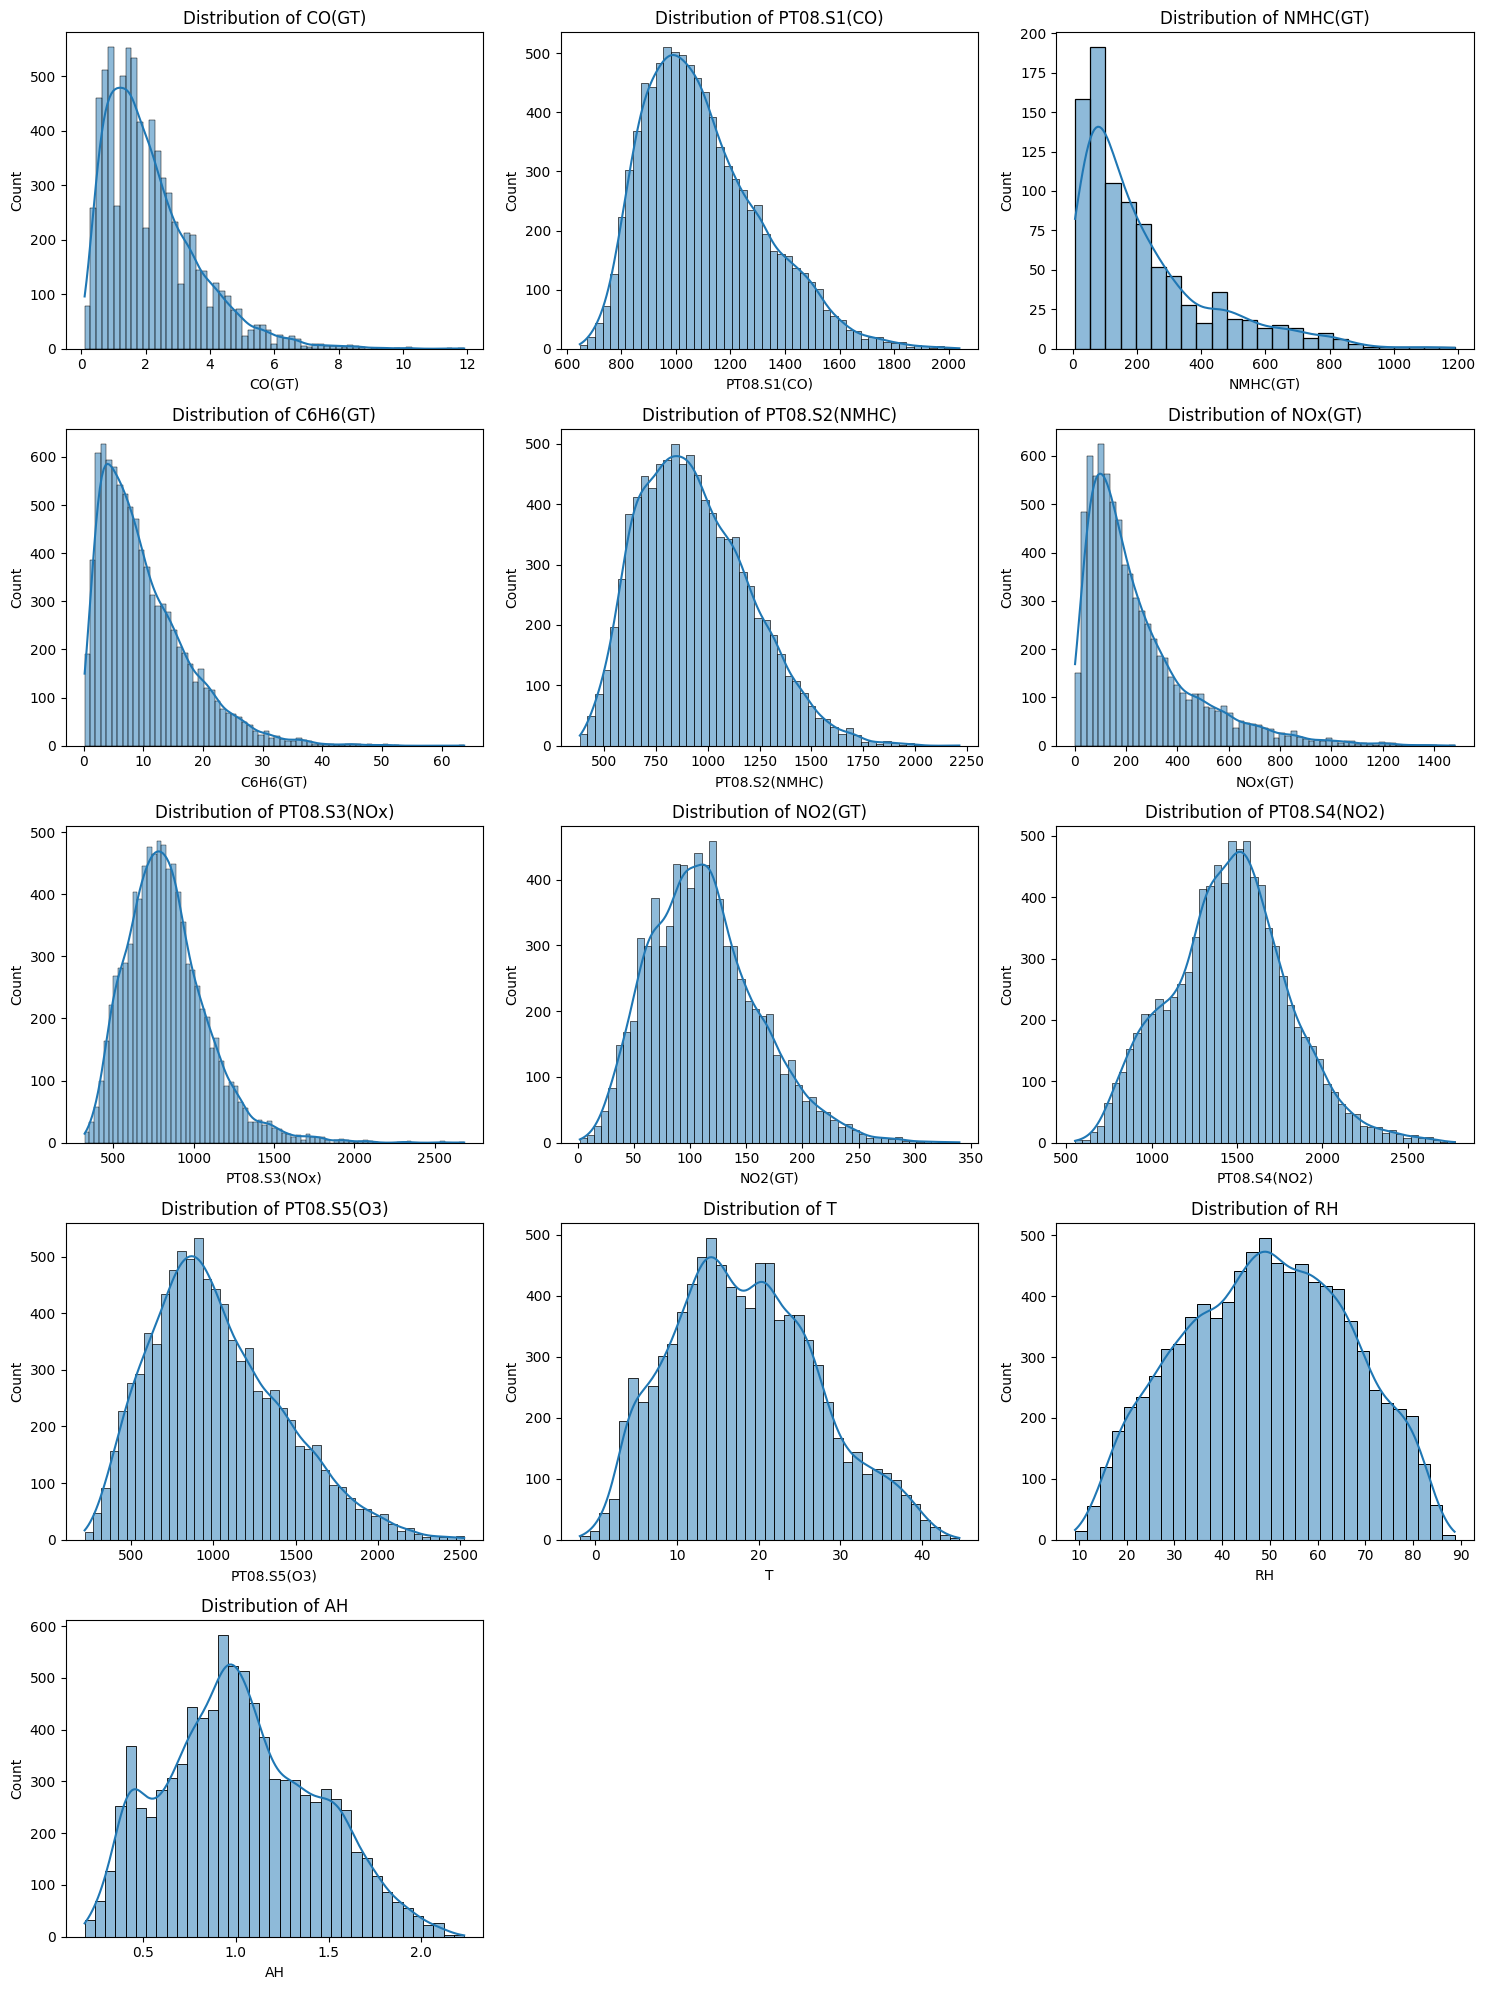

In [22]:
# Create histograms for all numeric columns
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_clean[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('figures/histograms.png')
plt.show()
plt.close()

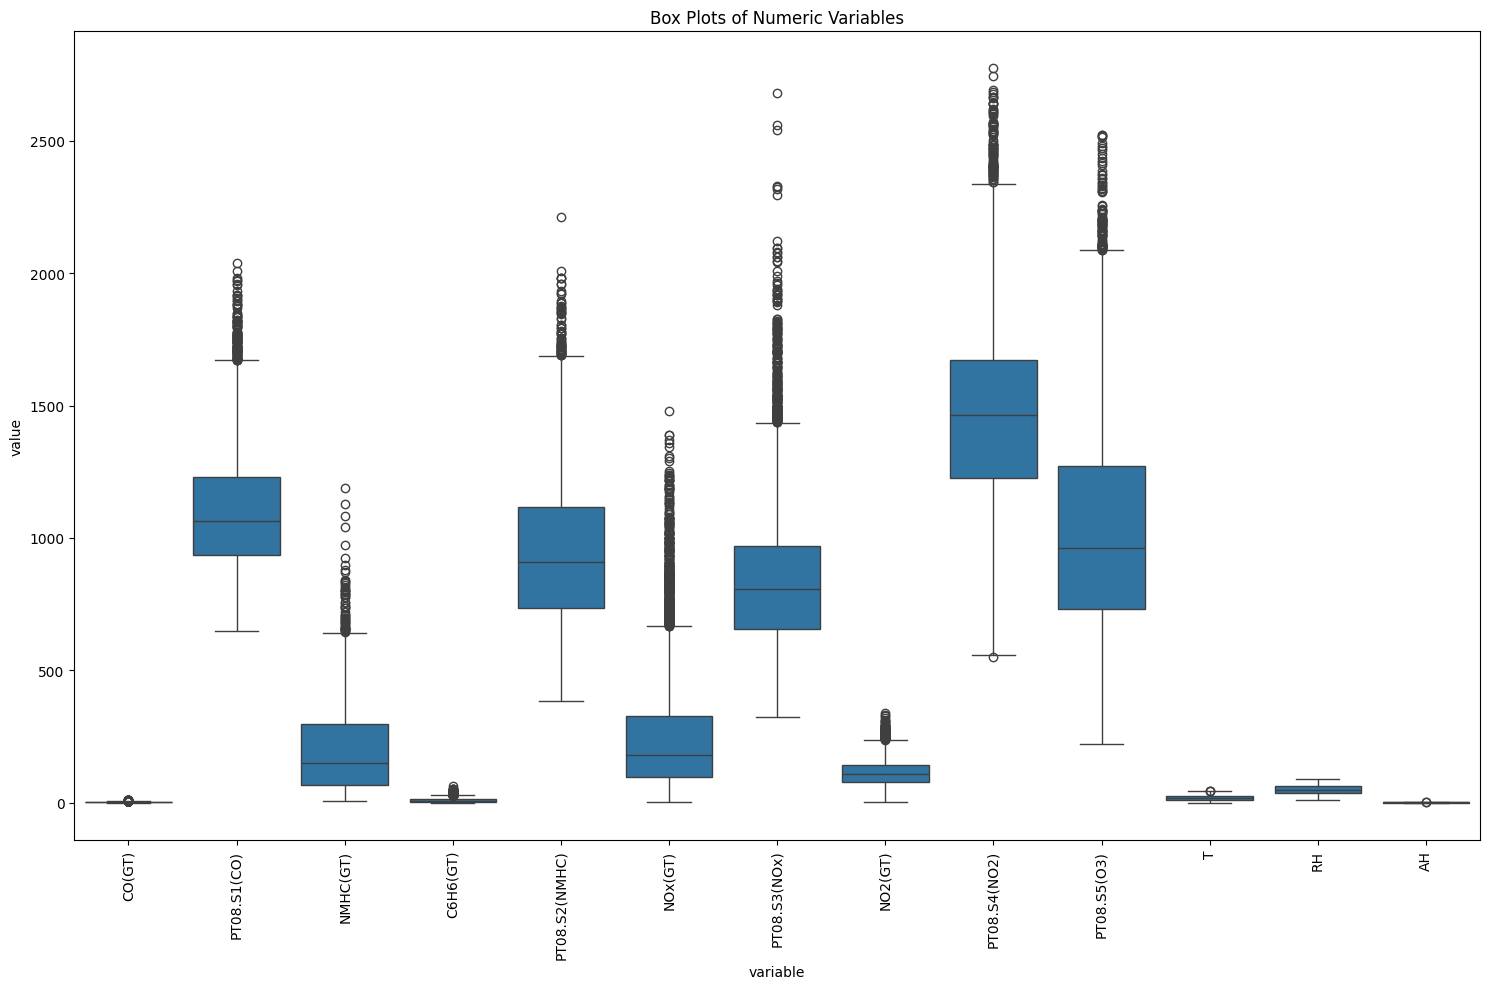

In [23]:
# Create box plots for all numeric columns
plt.figure(figsize=(15, 10))
df_clean_melt = pd.melt(df_clean[numeric_cols])
sns.boxplot(x='variable', y='value', data=df_clean_melt)
plt.xticks(rotation=90)
plt.title('Box Plots of Numeric Variables')
plt.tight_layout()
plt.savefig('figures/boxplots.png')
plt.show()
plt.close()

In [24]:
# Create time series plots for key pollutants
# First, ensure datetime format
df_clean['DateTime'] = pd.to_datetime(df_clean['Date'].astype(str) + ' ' + df_clean['Time'].astype(str))
df_clean = df_clean.set_index('DateTime')

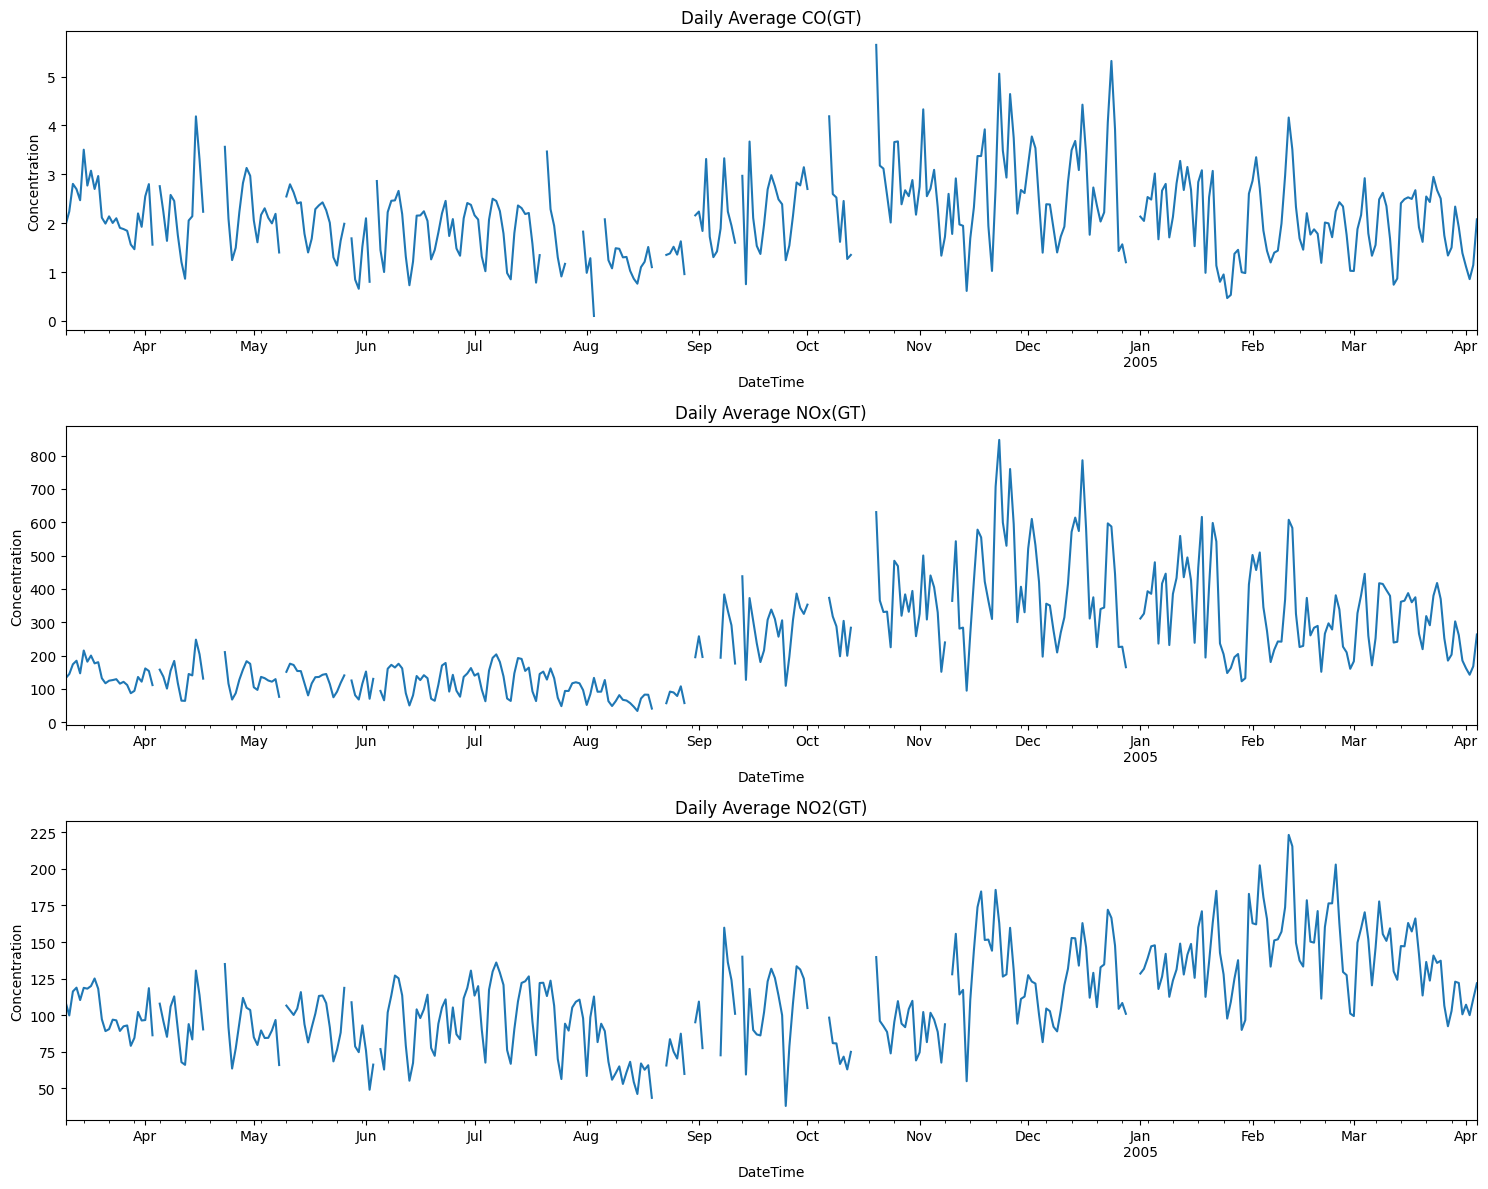

In [25]:
# Plot time series for CO, NOx, and NO2
pollutants = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']
plt.figure(figsize=(15, 12))
for i, pollutant in enumerate(pollutants):
    plt.subplot(3, 1, i + 1)
    df_clean[pollutant].resample('D').mean().plot()
    plt.title(f'Daily Average {pollutant}')
    plt.ylabel('Concentration')
plt.tight_layout()
plt.savefig('figures/time_series_pollutants.png')
plt.show()
plt.close()

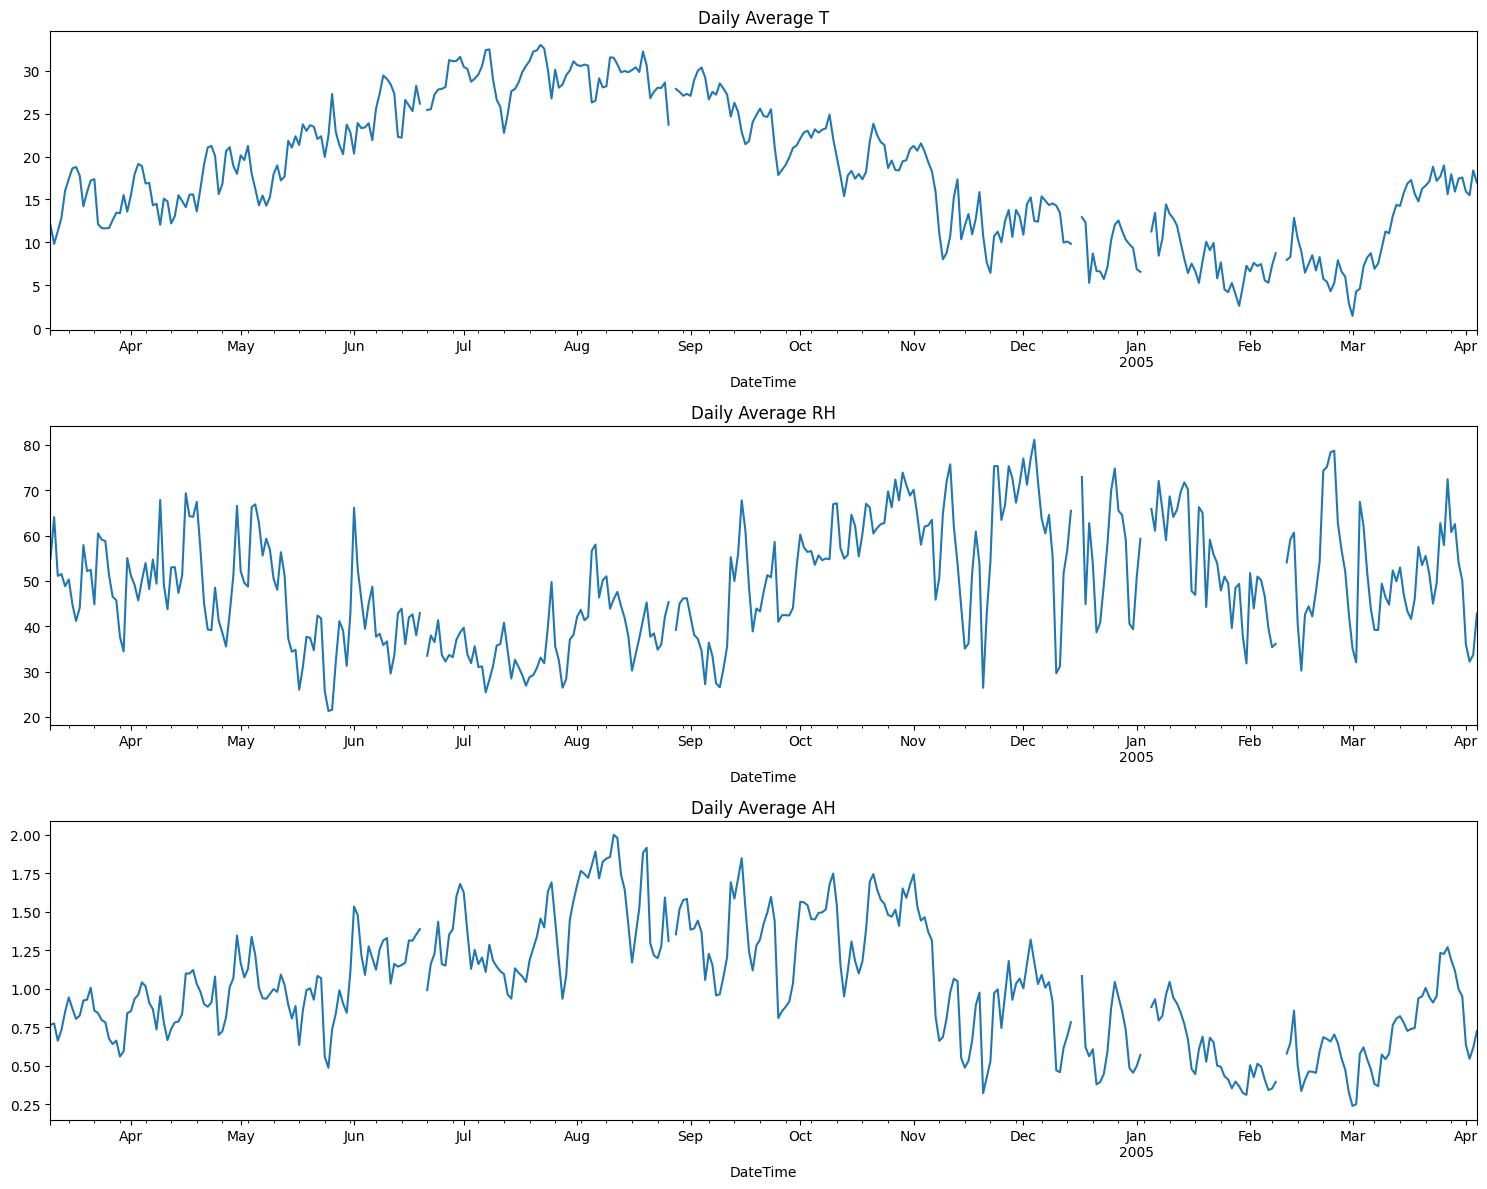

In [26]:
# Plot environmental variables
env_vars = ['T', 'RH', 'AH']
plt.figure(figsize=(15, 12))
for i, var in enumerate(env_vars):
    plt.subplot(3, 1, i + 1)
    df_clean[var].resample('D').mean().plot()
    plt.title(f'Daily Average {var}')
plt.tight_layout()
plt.savefig('figures/time_series_env.png')
plt.show()
plt.close()

<Figure size 1200x1000 with 0 Axes>

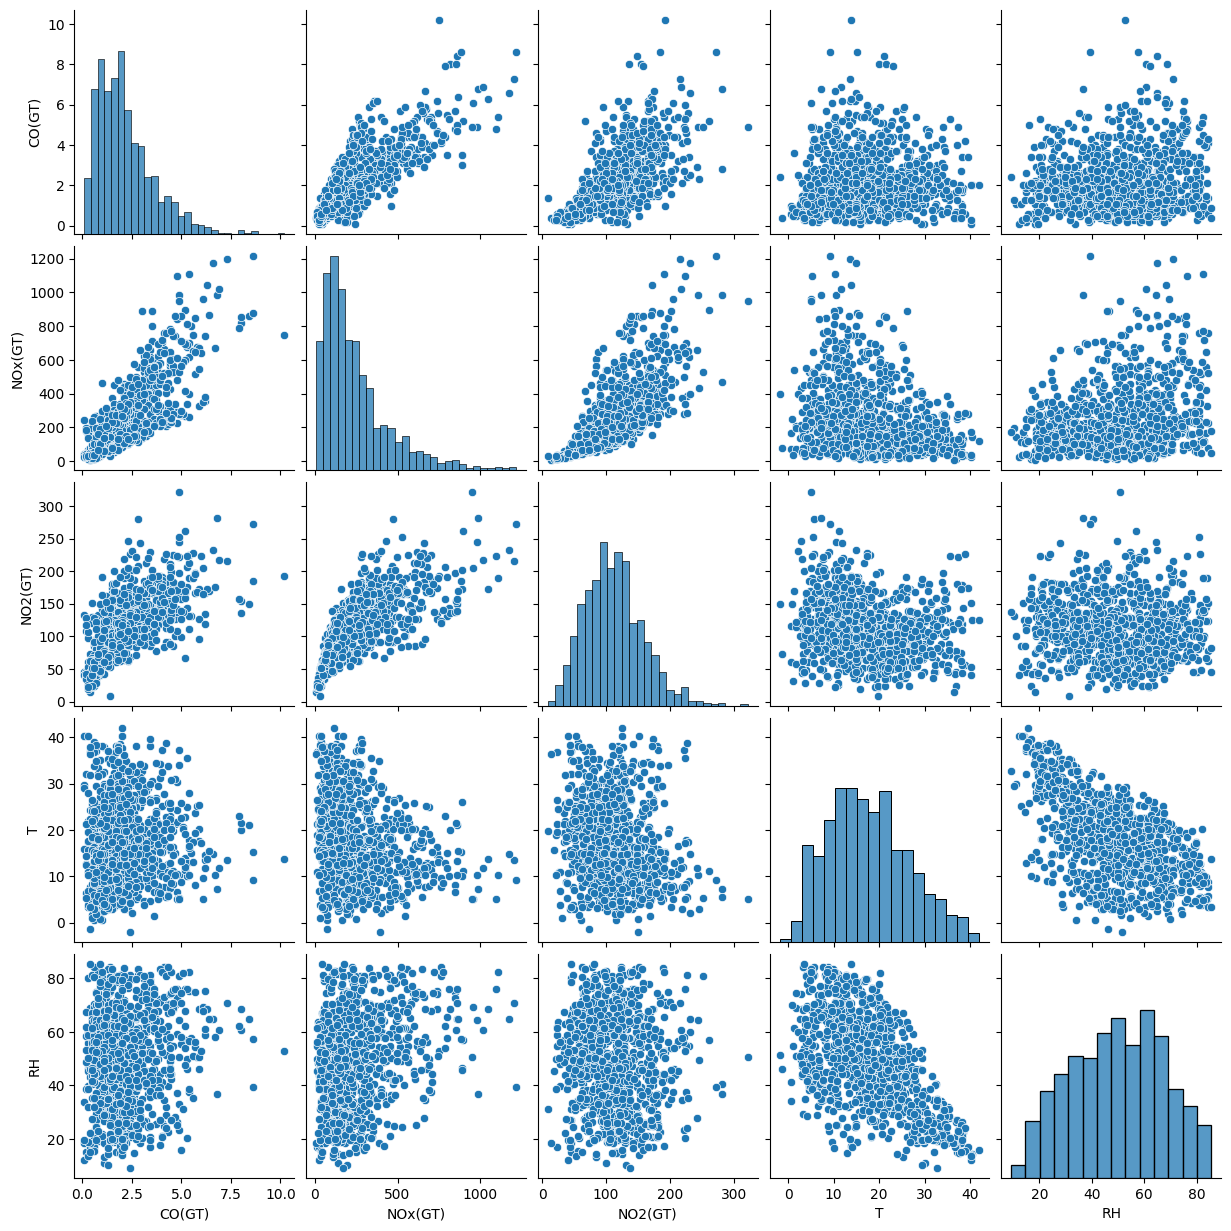

In [27]:
# Create a pair plot for key variables
key_vars = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH']
plt.figure(figsize=(12, 10))
sns.pairplot(df_clean[key_vars].dropna().sample(1000))  # Sample to speed up plotting
plt.savefig('figures/pairplot.png')
plt.show()
plt.close()

In [28]:
print("Exploratory data analysis completed. Visualizations saved to figures/ directory")

Exploratory data analysis completed. Visualizations saved to figures/ directory
